In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping



                 balance
date                    
2010-01-31  10067.223723
2010-02-28   9972.899399
2010-03-31  10029.685424
2010-04-30  10067.583656
2010-05-31  10112.986744
...                  ...
2024-02-29  13496.135033
2024-03-31  13315.199340
2024-04-30  13353.642357
2024-05-31  13414.903898
2024-06-30  13428.547875

[174 rows x 1 columns]


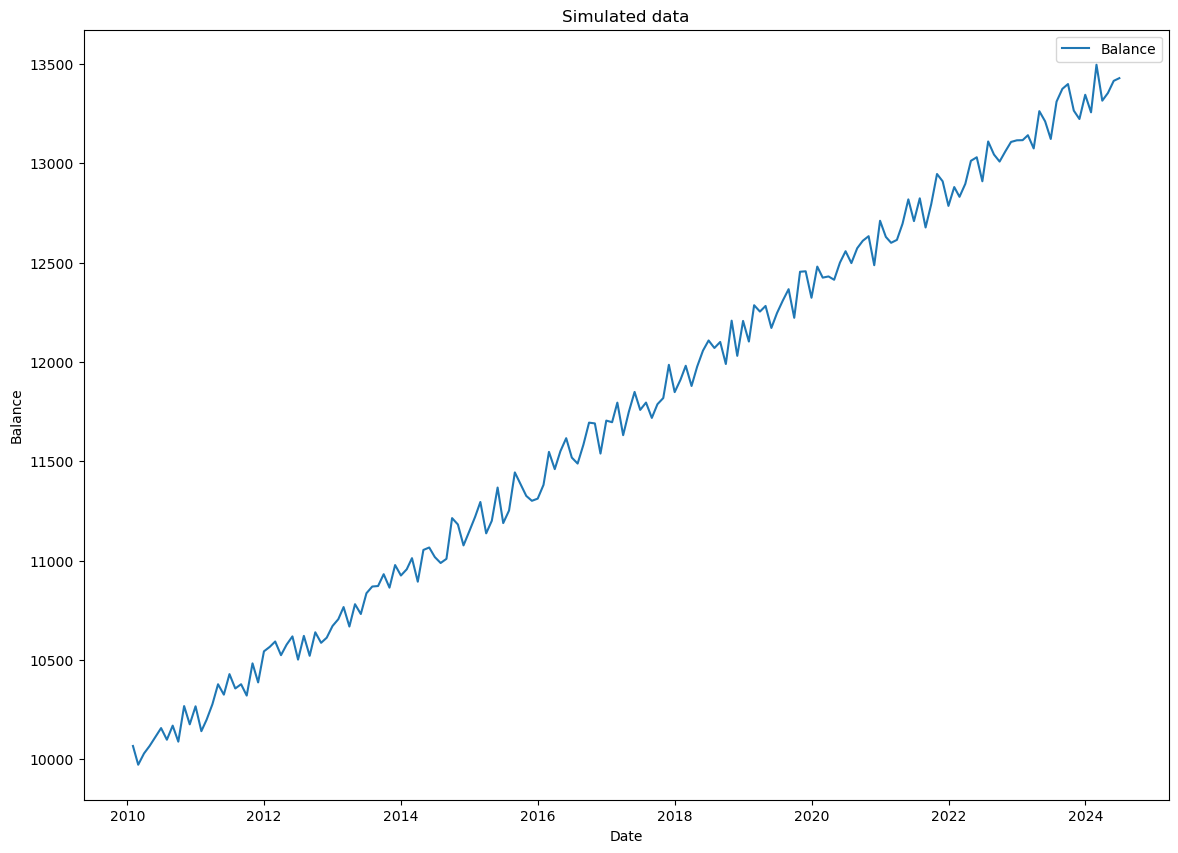

In [50]:
# Generating data with trend, random noise and seasonality 
def generate_monthly_data(start_date, end_date):
    date_rng = pd.date_range(start=start_date, end=end_date, freq='M')
    num_months = len(date_rng)
    
    # Genreate a base balance with random fluctuations
    base_balance = 10000
    noise_level = 0.01  
    trend_rate=0.002
    trend = [base_balance * (1 + trend_rate*i) for i in range(num_months) ]
    balances=[t+t*np.random.uniform(-noise_level,noise_level) for t in trend]
    
    df = pd.DataFrame({'date': date_rng, 'balance': balances})
    df.set_index('date', inplace=True)
    
    return df

# Generate monthly data with random noise
df = generate_monthly_data(start_date='1/1/2010', end_date='6/30/2024')

print(df)

#df.to_csv('df')


# Plotting 
plt.figure(figsize=(14, 10))
plt.plot(df.index, df['balance'], label='Balance')
plt.title('Simulated data')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.legend()
plt.show()


Epoch 1/50
4/4 [==============================] - 4s 306ms/step - loss: 0.1709 - val_loss: 0.3230
Epoch 2/50
4/4 [==============================] - 0s 24ms/step - loss: 0.0610 - val_loss: 0.0516
Epoch 3/50
4/4 [==============================] - 0s 24ms/step - loss: 0.0088 - val_loss: 0.0201
Epoch 4/50
4/4 [==============================] - 0s 39ms/step - loss: 0.0221 - val_loss: 0.0018
Epoch 5/50
4/4 [==============================] - 0s 23ms/step - loss: 0.0057 - val_loss: 0.0192
Epoch 6/50
4/4 [==============================] - 0s 24ms/step - loss: 0.0058 - val_loss: 0.0399
Epoch 7/50
4/4 [==============================] - 0s 24ms/step - loss: 0.0077 - val_loss: 0.0277
Epoch 8/50
4/4 [==============================] - 0s 22ms/step - loss: 0.0040 - val_loss: 0.0058
Epoch 9/50
4/4 [==============================] - 0s 26ms/step - loss: 0.0023 - val_loss: 3.8467e-04
Epoch 10/50
4/4 [==============================] - 0s 25ms/step - loss: 0.0033 - val_loss: 3.5561e-04
Epoch 11/50
4/4 [===

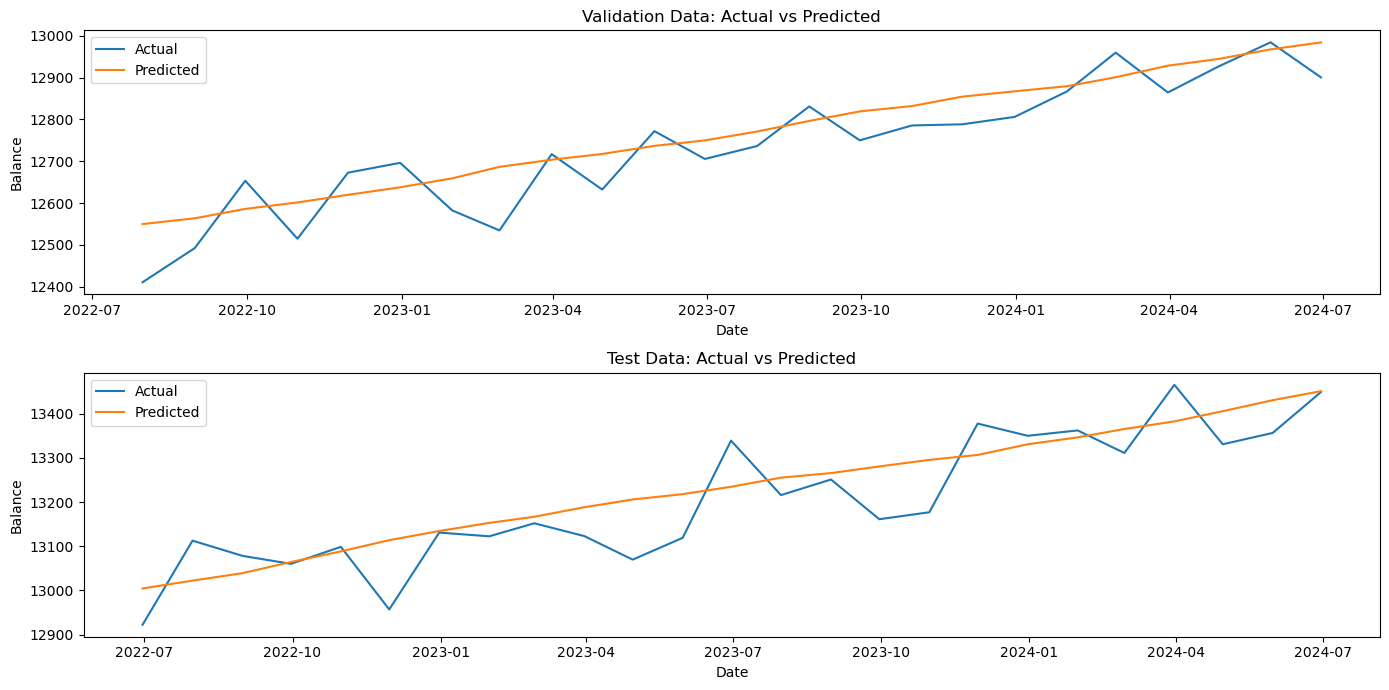

In [45]:
# Scale
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length, :]
        y = data[i + seq_length, :]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12  # Using 12 months as sequence length
X, y = create_sequences(df_scaled, seq_length)

# Split 
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Build 
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))  # Output layer predicting one feature (balance)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

# Predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

y_val_pred_inv = scaler.inverse_transform(y_val_pred)
y_val_inv = scaler.inverse_transform(y_val)
y_test_pred_inv = scaler.inverse_transform(y_test_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Evaluate - to add more metrics
mse_val = mean_squared_error(y_val_inv, y_val_pred_inv)
r2_val = r2_score(y_val_inv, y_val_pred_inv)
mse_test = mean_squared_error(y_test_inv, y_test_pred_inv)
r2_test = r2_score(y_test_inv, y_test_pred_inv)

print(f"Validation MSE: {mse_val}, Validation R²: {r2_val}")
print(f"Test MSE: {mse_test}, Test R²: {r2_test}")

# Plotting
plt.figure(figsize=(14, 7))

# Plot validation predictions vs actual
plt.subplot(2, 1, 1)
plt.plot(df.index[-len(y_val_inv):], y_val_inv, label='Actual')
plt.plot(df.index[-len(y_val_pred_inv):], y_val_pred_inv, label='Predicted')
plt.title('Validation Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.legend()

# Plot test predictions vs actual
plt.subplot(2, 1, 2)
plt.plot(df.index[-len(y_test_inv):], y_test_inv, label='Actual')
plt.plot(df.index[-len(y_test_pred_inv):], y_test_pred_inv, label='Predicted')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.legend()

plt.tight_layout()
plt.show()
